# Прогнозирование вероятности оттока пользователей для фитнес-центров

## Содержание: <a id='content'></a>
1. [Загрузка данных и предобработка (EDA)](#eda)
2. [Построение модели прогнозирования оттока клиентов](#models)
3. [Кластеризация клиентов](#clusters)
4. [Выводы и базовые рекомендации по работе с клиентами](#conclusion)

## Загрузка данных и предобработка (EDA) <a id='eda'></a>

На первом этапе проверим готовность исходного датасета к анализу: полнота данных, средние значения, распределения признаков и их корреляция.

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import warnings

In [2]:
# отключаем предупреждения
warnings.filterwarnings("ignore")

In [3]:
gym_churn = pd.read_csv('/datasets/gym_churn.csv')
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


В данных отсутсвуют пропущенные значения.  
Для удобства переведем названия колонок к нижнему регистру и заменим значения столбца `month_to_end_contract` на целочисленный тип:

In [5]:
gym_churn.columns = gym_churn.columns.str.lower()

In [6]:
gym_churn['month_to_end_contract'] = gym_churn['month_to_end_contract'].astype('int')

Посмотрим на средние значения и стандартные отклонения признаков:

In [7]:
gym_churn.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Исходя из показателей средних значений, можно сделать следующие выводы:
- распределение мужчин и женщин примерно одинаковое;
- большинство клиентов выбирают клуб рядом с домом;
- почти половина клиентов являются сотрудниками компании-партнёра клуба;
- примерно треть пришли в клуб по акции "приведи друга";
- менее половины посещади групповые занятия;
- средний возраст - 29 лет;
- количество посещений в неделю как правило меньше двух;
- 26% посетителей попали в отток.  

Помимо средних и стандартных отклонений мы теперь также наверняка знаем, какие из колонок имеют бинарные значения, а какие количественные.  

Посмотрим на средние значения признаков в двух группах - тех, кто ушел в отток и тех, кто остался:

In [8]:
gym_churn.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Здесь мы видим, что в среднем на удержание клиента лучше сказывается партнерство с работодателем, покупка первого абонемента по акции и посещение групповых занятий. Ушедшие клиенты в среднем моложе, имеют меньший оставшийся срок действия абонемента и в текущем месяце посещали зал раз в неделю.

Построим столбчатые диаграммы для бинарных признаков, чтобы сравнить эти показатели для тех кто попал и не попал в отток:

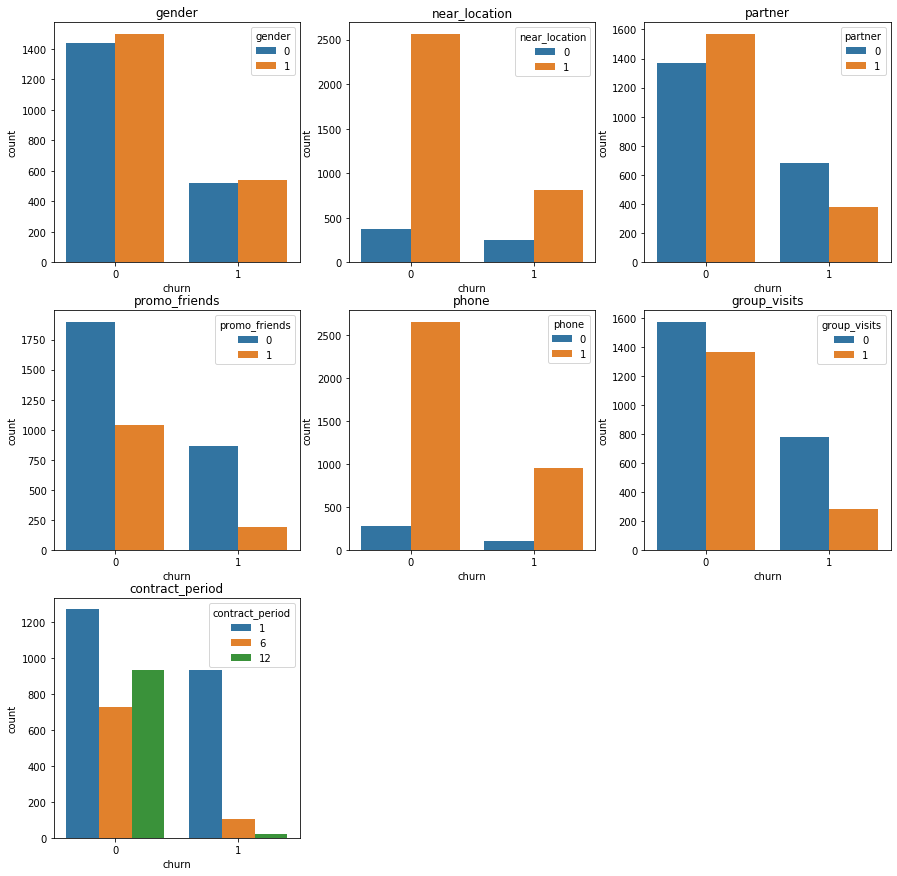

In [9]:
bin_columns = ['gender', 
               'near_location', 
               'partner', 
               'promo_friends', 
               'phone', 
               'group_visits', 
               'contract_period']

plt.figure(figsize=(15,15))
for i, col in enumerate(bin_columns):
    sns.countplot(x='churn', hue=col, data=gym_churn, ax=plt.subplot(3,3,i+1)).set_title(col)

По всем показателям процент оттока меньше. Различающееся распределение внутри показателя наблюдается в столбце `partner` - сотрудники партнеров охотнее остаются клиентами. Также очень мало клиентов уходят, когда их абонемент дейстует 6 и более месяцев.

Для количественных признаков построим боксплот и также сравним распределения:

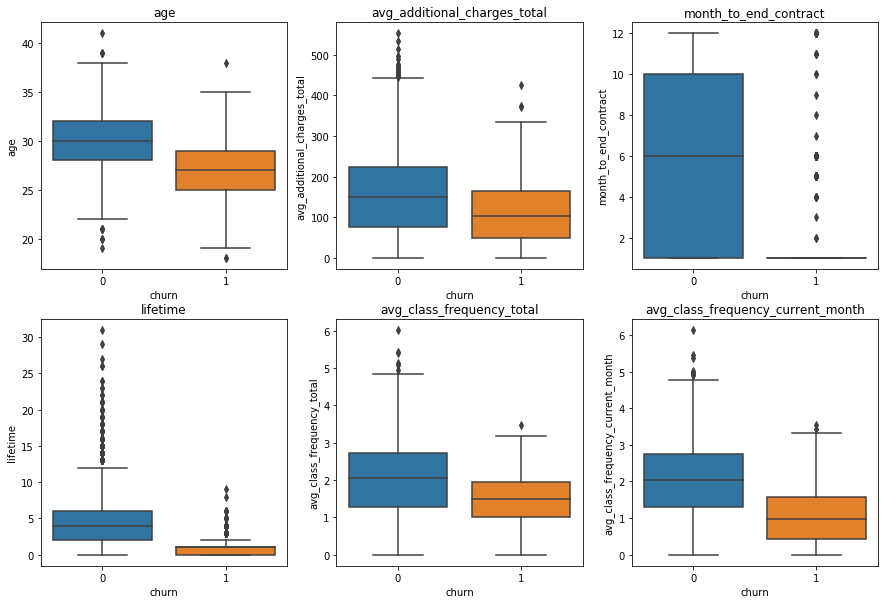

In [10]:
numeric_columns = ['age', 
                   'avg_additional_charges_total', 
                   'month_to_end_contract', 
                   'lifetime', 
                   'avg_class_frequency_total', 
                   'avg_class_frequency_current_month']
plt.figure(figsize=(15,10))
for i, col in enumerate(numeric_columns):
    sns.boxplot(x='churn', y=col, data=gym_churn, ax=plt.subplot(2,3,i+1))
    plt.title(col)

Сразу заметна разница в распределении количества месяцев до окончания абонемента - среди отточных клиентов очень мало тех, у кого этот срок составлял больше месяца. В разрезе дополнительных затрат можно предположить следующую закономерность - чем больше клиент тратит на дополнительные услуги, тем реже он нас покидает. Lifetime чаще всего не превышает 3 месяца для тем, кто попадает в отток.

Посмотрим как коррелируют наши параметры, для наглядности отобразив матрицу корреляций на тепловой карте:

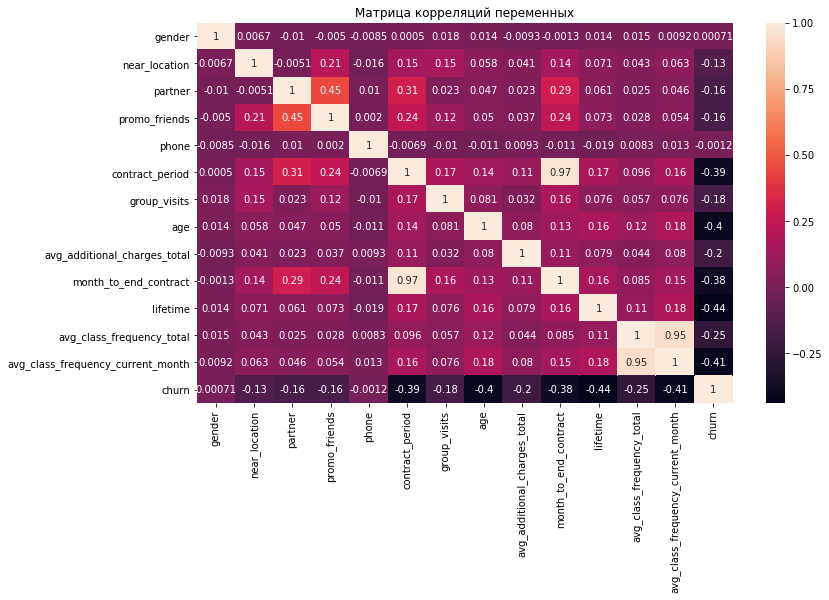

In [11]:
cm = gym_churn.corr()
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(cm, annot=True)
plt.title('Матрица корреляций переменных')
plt.show()

Для большинства параметров не характерна линейная зависимость друг с другом. Здесь мы можем выделить сильную корреляцию между количеством месяцев до конца контракта и его общим периодом, а также между средним количество посещений в неделю и месяц - это очевидные признаки мультиколлинеарности.  
Дольно заметная зависимость наблюдается между партнерством с компанией и промо "приведи друга", скорее всего сотрудники компаний пользуются этим предложением для привлечения своих коллег. Также можно предположить, что сотрудники таких компаний приобретают абонемент сразу на год.

Таким образом мы провели предобработку и исследовательский анализ данных и выявили некоторые начальные закономерности и предположения, которые в дальнейшем помогут нам построить предсказывающую модель.

## 2. Построение модели прогнозирования оттока клиентов <a id='models'></a>
[Назад к оглавлению](#content)

На следующем этапе мы построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Для этого поочередно воспользуемся **логистической регрессией** и **случайным лесом** и сравним результаты их работы по нескольким метрикам.

Для начала создадим матрицу объект-признак и вектор значений целевой переменной для наших данных:

In [12]:
X = gym_churn.drop(['churn'], axis=1)
y = gym_churn['churn']

In [28]:
gym_churn

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0,1
1,0,1,0,0,1,12,1,31,113.202938,12,7,1.922936,1.910244,0,0
2,0,1,1,0,1,1,0,28,129.448479,1,2,1.859098,1.736502,0,3
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0,0
4,1,1,1,1,1,1,0,26,198.362265,1,3,1.113884,1.120078,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12,8,2.284497,2.349070,0,0
3996,0,1,0,0,1,1,1,29,68.883764,1,1,1.277168,0.292859,1,3
3997,1,1,1,1,1,12,0,28,78.250542,11,2,2.786146,2.831439,0,0
3998,0,1,1,1,1,6,0,32,61.912657,5,3,1.630108,1.596237,0,0


Разделим эти переменные на обучающую и валидационную выборки в соотношении 80/20. Зафиксируем параметр random_state.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Для прогнозирования целевой переменной определим функцию, которая на вход будет принимать алгорит обучения, а на выходе возвращать значения трех метрик для нее: accuracy, precission и recall: 

In [14]:
def predictions(m):
    model = m                       #создаем модель
    model.fit(X_train, y_train)     # обучаем ее
    y_pred = model.predict(X_test)  # предсказываем значения валидационной выборки
    print('Модель: {}\nAccuracy: {:.2f}\nPrecision: {:.2f}\nRecall: {:.2f}\n'.format(m, 
                                                                 accuracy_score(y_test, y_pred), 
                                                                 precision_score(y_test, y_pred),
                                                                 recall_score(y_test, y_pred)))

In [15]:
predictions(LogisticRegression())

Модель: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 0.93
Precision: 0.86
Recall: 0.83



Доля праивльных ответов (accuracy) имеет высокий показатель - 93%. Однако ранее мы выявили, что наши классы не сбалансированы - доля оттока составляет примерно четверть от числа клиентов, поэтому данная метрика не является показательной.  
Точность (precission) - это доля правильных ответов интересующего нас класса. В 86% наша модель правильно присваивала клиенту класс 1, тем самым предсказывая его уход в следуюшем месяце.  
Полнота (recall) показывает сколько реальных объектов класса 1 смогла обнаружить модель, в нашем случае этот показатель равен 83%.

Сравним эти метрики после применения алгоритма случайного леса.  
Чтобы выбрать наиболее подходящие максимальную глубину дерева и количество выборок применим GridSearchCV, где в качестве параметров передадим ему словарь значений n_estimators и max_depth:

In [16]:
params = ({'n_estimators':[50, 100, 150, 200], 
           'max_depth':[3,6,9,12,15]})
rf = RandomForestClassifier()
grid_cv = GridSearchCV(rf, params, scoring='f1')

In [17]:
grid_cv.fit(X_train, y_train)
grid_cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Наилучшей максимальной глубиной дерева оказалось 12, а количество выборок составит 200. Передадим алгоритм с этими значениями в функцию:

In [18]:
predictions(RandomForestClassifier(n_estimators=200, max_depth=12, random_state=0))

Модель: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Accuracy: 0.91
Precision: 0.84
Recall: 0.81



Таким образом мы имеем следующие результаты:

|Метрика|LogisticRegression|RandomForestClassifier|
|--|--|--|
|Accuracy|0.93|0.91|
|Precision|0.86|0.84|
|Recall|0.83|0.81|

Логистическая регрессия показала более высокие значения метрик, поэтому будем считать эту модель лучше.

## 3. Кластеризация клиентов <a id='clusters'></a>
[Назад к оглавлению](#content)

Последнее, что нужно сделать перед тем, как предложить выводы - провести кластеризацию клиентов. Обучать модель кластеризации будем на основании алгоритмов K-Means и агломеративной иерархической кластеризации.  
Перед обучение моделей необходимо стандартизировать матрицу объект-признак:

In [19]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

Построим дендрограмму на основе матрицы расстояний стандартизированных данных:

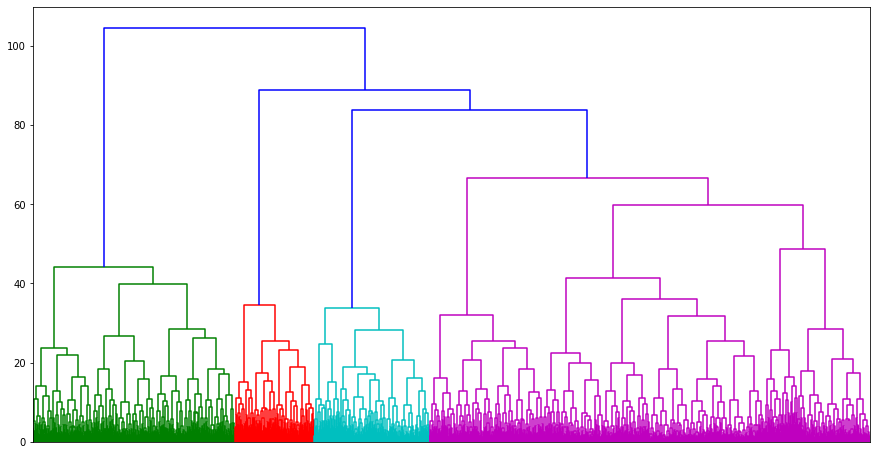

In [20]:
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 8))  
dendrogram(linked, orientation='top', no_labels=True)
plt.show() 

Предложенное оптимального число кластеров равно 4 - каждый кластер соответствует одному цвету.  
Можем разделить последний полученный кластер на 2 из-за его большого размера и передадим это число как количество кластеров для обучения модели алгоритмом KMeans:

In [21]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)

Добавим полученные кластеры в качестве столбца к исходной таблице, сгруппируем по ним данные и посмотрим на средние значения:

In [22]:
gym_churn['cluster'] = labels
gym_churn.drop(['churn'], axis=1).groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.502473,0.522078,0.495050,0.485737,0.560335
near_location,0.959446,0.862338,0.000000,1.000000,0.976105
partner,0.783383,0.470130,0.463366,0.350238,0.356033
promo_friends,0.574679,0.306494,0.079208,0.240095,0.229391
phone,1.000000,0.000000,1.000000,1.000000,0.998805
contract_period,10.884273,4.787013,2.352475,1.948494,2.665472
group_visits,0.543027,0.425974,0.215842,0.341521,0.473118
age,29.980218,29.301299,28.477228,28.167987,30.127838
avg_additional_charges_total,160.706969,143.957664,135.457501,131.622204,161.724258
month_to_end_contract,9.950544,4.475325,2.198020,1.856577,2.455197


Распределение клиентов по полу во всех кластерах получилось примерно одинаковым, так же нет особых различий среднего возраста. Для **0** кластера характерно близкое расположение к дому, партнерство компании, длительный абонемент, который начал действовать только пару месяцев назад. Они достаточно много тратят на дополнительные услуги клуба, нередко посещают групповые занятия и тренируются дважды в неделю.  
В кластер **1** попали те клиенты, у которых отсутствует номер телефона. Они также в основном живут рядом, но число сотрудников компаний-партнеров меньше. Среди них реже встречаются клиенты с длительными абонементами, и в среднем приходится 2 занятия в неделю.  
Для кластера **2** характерна удаленность клиентов от клуба. При этом половина из них так же являются сотрудниками компании-партнера, однако практически не пользуются промокодом от друзей. Имеют непродолжительные абонементы и соответственно небольшой lifetime. Среднее количество посещений уже меньше предыдущих кластеров.  
В **3-м** кластере наибольшее количество рядом живущих клиентов. Чаще всего они не являются сотрудниками партнеров и также имеют непродолжительный контракт. За последний месяц такие клиенты посещали занятия раз в неделю.  
Наконец, кластер **4** похож по своим характеристикам на предыдущий, за исключением более высоких трат на доп.услуги и количества посещений - здесь они показывают максимальное значение в сравнении с остальными кластерами.

Построим распределения признаков по кластерам:

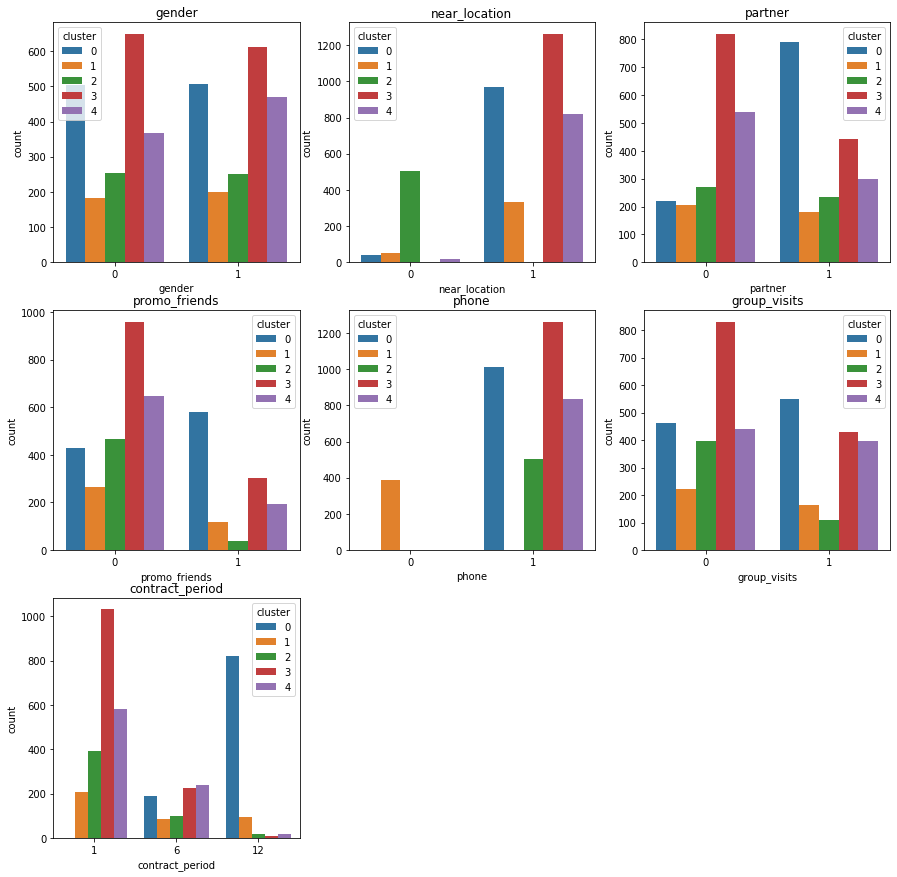

In [23]:
plt.figure(figsize=(15,15))
for i, col in enumerate(bin_columns):
    sns.countplot(x=col, hue='cluster', data=gym_churn, ax=plt.subplot(3,3,i+1)).set_title(col)

Исходя из диаграммы, наибольшее число клиентов попали в кластеры 3 и 0, наименьшее в кластере 1. Такая визуализация подтверждает выводы, сделанные на основе средних значений. В 3 кластере больше всего тех, кто приобрел абонемент на месяц.

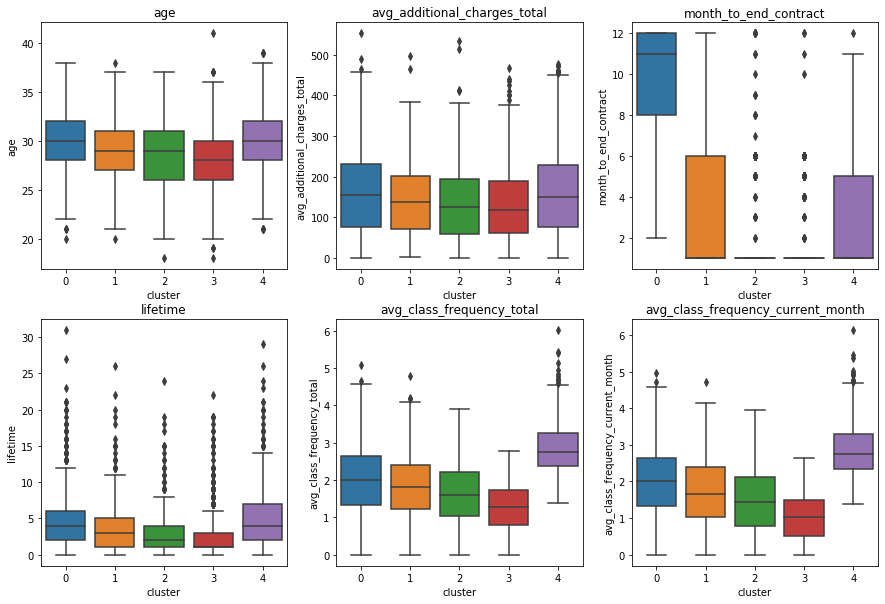

In [24]:
plt.figure(figsize=(15,10))
for i, col in enumerate(numeric_columns):
    sns.boxplot(x='cluster', y=col, data=gym_churn, ax=plt.subplot(2,3,i+1))
    plt.title(col)

Диаграмма размаха показывает сильную разницу количества месяцев до окончания абонемента между кластерами: кластер 0 имеет наибольшее значение, 1 и 4 чаще всего непродолжительные, однако с большим разбросом, а 2 и 3 практически всегда имеют месяц до окончания. Также, как уже было отмечено, выделяется количество посещений 4 кластера - оно превосходит все остальные по данному показателю.

Наконец, изучим долю оттока среди кластеров:

,cluster,churn_rate
0,0,0.027695
1,1,0.267532
2,2,0.443564
3,3,0.514263
4,4,0.068100


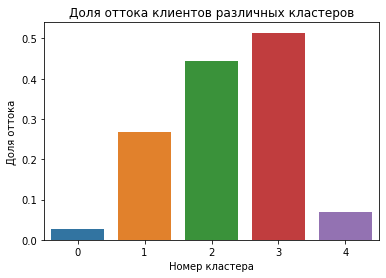

In [25]:
churn_rate = (gym_churn.groupby('cluster', as_index=False)
              .agg({'churn':'mean'})
              .rename(columns={'churn':'churn_rate'}))

display(churn_rate)

sns.barplot(x='cluster', y='churn_rate', data=churn_rate)
plt.title('Доля оттока клиентов различных кластеров')
plt.xlabel('Номер кластера')
plt.ylabel('Доля оттока')
plt.show()

Все кластеры отличаются между собой по доле оттока. Наиболее склонны к оттоку номера 2 и 3 - около половины клиентов уходят. Лучший показатель у кластера 0 - отток менее 3 процентов. Вспомним, что для него характерно: 
- близкое расположение к дому; 
- партнерство компании; 
- длительный абонемент; 
- много трат на допольнительные услуги клуба; 
- частое посещение групповых занятий; 
- тренировки дважды в неделю.

Также всего 7 процентов клиентов уходят из кластера 4. Его особенность - большие затраты на дополнительные услуги и большее количество занятий в неделю при небольшой длительности абонемента.

## 4. Выводы и базовые рекомендации по работе с клиентами <a id='conclusion'></a>
[Назад к оглавлению](#content)

Таким образом мы изучили основные характеристики и поведения клиентов, спрогнозировали вероятность оттока на уровне следующего месяца, сформировать типичные портреты клиентов и проанализировали основные признаки, наиболее сильно влияющие на отток.

При исследовании средних значений признаков в двух группах мы определили, что 26% посетителей попали в отток. Распределение мужчин и женщин в выборке оказалось примерно одинаковое, их средний возраст - 29 лет. Большинство клиентов выбирают клуб рядом с домом, почти половина из них являются сотрудниками компании-партнёра клуба и примерно треть пришли в клуб по акции "приведи друга". Количество посещений - менее двух и посещение групповых занятий не добирает 50 %.  
По средним значениям признаков в двух группах увидели, что в среднем на удержание клиента лучше сказывается партнерство с работодателем, покупка пеорвого абонемента по акции и посещение групповых занятий. Среди отточных клиентов очень мало тех, у кого этот срок составлял больше месяца. В разрезе дополнительных затрат можно предположить следующую закономерность - чем больше клиент тратит на дополнительные услуги, тем реже он нас покидает.  
Для большинства параметров не характерна линейная зависимость друг с другом. Сильная корреляция наблюдалась между количеством месяцев до конца контракта и его общим периодом, а также между средним количествоv посещений в неделю и месяц, что является признаками мультиколлинеарности. Есть зависимость между партнерством с компанией и промо "приведи друга", скорее всего сотрудники компаний пользуются этим предложением для привлечения своих коллег. Также можно предположить, что компании приобретают для своих сотрудников абонементы сразу на год.

Далее мы проводили построение модели прогнозирования оттока клиентов при помощи двух алгоритмов: логистическая регрессия и случайный лес. В качестве метрик для оценки прогнозов мы применяли долю правильных ответов, точность и полноту. Для логистической регресси показатель Accuracy составил 93% и 91 для случайного леса, однако, в наших выборках имеется несбалансированность классов - четверть ушедших клиентов - поэтому данная метрика не может являться определяющей. Точность и полнота составили 86% и 83% соответственно для регрессии и 84% и 81% для леса. На основании этих показателей считаем, что алгритм логистической регрессии лучше справился с прогнозиронием оттока клиентов.  

На финальном этапе проводилась кластеризация клиентов. Модель кластеризации мы обучали двумя алгоритмами - агломеративной иерархической кластеризацией и K-Means. Первый метод основан на построении дендрограммы матрицы расстояний стандартизированных независимых переменных. Результат его работы предложил разделить клиентов на 4 кластера.  
Так как один из предложенных кластеров имел достаточно большой размер, при делении методом K-Mean было решено использовать 5 категорий клиентов. В результате мы выявили следующие характерные особенности в каждом кластере:
**0**: близкое расположение к дому, партнерство компании, длительный абонемент, который начал действовать только пару месяцев назад. Они достаточно много тратят на допольнительные услуги клуба, нередко посещают групповые занятия и тренируются дважды в неделю.  
**1**: отсутствует номер телефона, в основном живут рядом, но число сотрудников компаний-партнеров меньше. Среди них реже встречаются клиенты с длительными абонементами, и в среднем приходится 2 занятия в неделю.  
**2**: удаленность клиентов от клуба, половина из них так же являются сотрудниками компании-партнера, однако практически не пользуются промокодом от друзей. Имеют непродолжительные абонементы и соответственно небольшой lifetime. Среднее количество посещений уже меньше предыдущих кластеров.  
**3**: наибольшее количество рядом живущих клиентов, чаще всего не являются сотрудниками партнеров и также имеют непродолжительный контракт. За последний месяц такие клиенты посещали занятия раз в неделю.  
**4**: схож с предыдущим, за исключением более высоких трат на доп.услуги и количества посещений - здесь они показывают максимальное значение в сравнении с остальными кластерами.  
Наибольшее число посетителей попали в кластеры 0 и 3. Наилучшие кластеры по доли оттока 0 и 4 - доля ушедших клиентов в них 2 и 7 процентов соответственно. Наибольший отток наблюдается в кластере 3.

Исходя из проведенного исследования можно предложить следующие рекомендации для стратегии взаимодействия с клиентами и их удержания:
1. Стимулировать клиентов на покупку длительных абонементов. Это можно сделать за счет проведения акций и/или предоставления скидок на продление действующего абонемента.
2. Расширять сеть компаний-партнеров. Компенсация фитнеса - одна из наиболее популярных условий работы в компаниях. Связь с фирмами, находящимися поблизости с клубом положительно скажется на привлечение их сотрудников.
3. Обратить внимание на привлечение клиентов на групповые занятия. Можно сделать бесплатное пробное занятие, а также проводить акции для них. Также стоит максимально разнообразить ассортимент проводимых занятий, например, проведя анкетирование клиентов для выявления их пожеланий.
4. Стимулировать на более частое посещение. Этому может поспособствовать включение в абонимент бесплатного занятия с тренером и составление индивидуальной программы тренировок - часто среди клиентов много тех, кто занимается не систематизированно, что также может способствовать потери интереса и последующему оттоку.